In [1]:
# read IEX_TOKEN and IEX_API_VERSION from .env file

import os

with open('.env', 'r') as env:
    os.environ.update({line.split('=')[0].strip(): line.split('=')[1].strip() for line in  filter(lambda li: '=' in li, env.read().split('\n'))})    

In [8]:
from lib.utils import *

In [10]:
import iexfinance
import pandas as pd

# Setup cache for requests
import datetime
from iexfinance.stocks import Stock
import requests_cache

expiry = datetime.timedelta(days=100)
session = requests_cache.CachedSession(cache_name='cache',
                                       backend='sqlite',
                                       expire_after=expiry)

vuke = Stock('VUKE-LN')

"""
purchased on 
Order summary
Estimated value more information £5,000.00 
Order number 5674775
Status updated
Date 03 March 2021
Time 10:16
Actual contract cost
Value £4,977.62
Settlement price £29.63
Contract total £4,977.62
"""

no_shares = 168.0000
buy_price = 29.63

price = vuke.get_price()
price = price['VUKE-LN'].values[0]

value = price * no_shares
returns = (price - buy_price)/price
print(f'value: {value}, return: {returns*100}%')

import json
import pandas as pd

# Static data
emea_cty_codes = ['AT','BE','BG','HR','CY','CZ','DK','EE','FI','FR','DE','GR','HU','IE','IT','LV','LT','LU','MT','NL','PL','PT','RO','SK','SI','ES','SE','GB']

with open('./data/iex_exchanges.json', 'r') as fil:
    df = pd.read_json(fil)
iex_exchanges = df

from iexfinance.refdata import get_region_symbols

def download_symbol_static():
    df = pd.DataFrame()
    for cty_code in emea_cty_codes:
        if cty_code in iex_exchanges.region.values:
            symbols = get_region_symbols(cty_code)
            if len(symbols) == 0:
                print(f'cty_code={cty_code} not found')
                continue
            df = df.append(symbols)
        else:
            print(f'cty_code={cty_code} is not supported by iex')
    all_emea_symbols = df
    all_emea_symbols.to_csv('data/all_emea_symbols.csv')
    return all_emea_symbols

# EMEA Universe
all_emea_symbols = pd.read_csv('./data/all_emea_symbols.csv')

# FTSE 100 data
ftse_companies = pd.read_csv('./data/ftse100.csv')
ftse_tickers = list(map(lambda tick: f'{tick}-LN', ftse_companies.Code))

# data on vanguard etfs
vg_etfs = pd.read_csv('/home/rory/dev/investment-analysis/data/vanguard_fund_summaries.csv')
vanguard_funds = all_emea_symbols[all_emea_symbols.name.str.contains('Vanguard')]
vanguard_funds.name

# Vanguard etf tickers
tickers=list(map(lambda it: it.replace(' ', '-'), list(vg_etfs.Bloomberg)))


value: 5055.96, return: 1.5451071606579163%


In [11]:
################
# Model Features
################
# VG ETF prices
vg_etf_basket = Stock(tickers, session=session)
vg_etf_prices = vg_etf_basket.get_historical_prices(range='5y')
vg_etf_prices = process_basket_data(vg_etf_prices)

# VG Momentum funds
momentum_etfs = Stock(list(vanguard_funds[vanguard_funds.symbol.str.contains('VMOM')].symbol.values), session=session)
momentum_prices = momentum_etfs.get_historical_prices(range='5y')
momentum_prices = process_basket_data(momentum_prices)

# FTSE 100 names
ftse_basket = Stock(list(ftse_tickers[0:100]), session=session)
ftse_basket_prices = ftse_basket.get_historical_prices(range='5y')
ftse_basket_prices = process_basket_data(ftse_basket_prices)

# Filter out columns with too few observations
mask = [tick for tick in filter(lambda ticker: ftse_basket_prices.loc[ticker].close.size >=1200, ftse_basket_prices.index.levels[0])]
ftse_basket_prices = ftse_basket_prices.loc[mask]


####################
# Prediction Targets
####################
# FTSE100 INDEX
ftse100 = Stock('VUKE-LN', session=session)
ftse100_prices = ftse100.get_historical_prices(range='5y')
ftse100_prices.index = pd.to_datetime(ftse100_prices.index)

ftse250 = Stock('VMID-LN', session=session)
ftse250_prices = ftse250.get_historical_prices(range='5y')
ftse250_prices.index = pd.to_datetime(ftse250_prices.index)
ftse250_prices


ftse_basket_prices.index.levels[0]

ftse_prediction = normalise_basket(ftse_basket_prices, 'returns').dropna()
ftse_prediction['index'] = daily_returns(ftse100_prices.close.astype('float'))
ftse_prediction['target'] = ftse_prediction['index'].astype('float').apply(lambda ret: 1 if ret > 0 else 0)

ftse_prediction = ftse_prediction.dropna()[1:]


In [12]:
ftse_prediction['index']

2016-03-14    0.004692
2016-03-15   -0.005928
2016-03-16    0.006325
2016-03-17   -0.006285
2016-03-18   -0.002530
                ...   
2021-03-04   -0.000338
2021-03-05   -0.004654
2021-03-08    0.013347
2021-03-09    0.002852
2021-03-10   -0.001171
Name: index, Length: 1260, dtype: float64

In [13]:
import sqlite3
con=sqlite3.connect('./example.db')
ftse_prediction.to_sql(name='ftse_prediction', if_exists='replace', con=con)

In [14]:
## apply lag to x of 1, so we only ever use yesterday's close price of components
period_lag = -1
ftse_prediction['target'] = ftse_prediction.target.shift(period_lag)
ftse_prediction['index'] = ftse_prediction['index'].shift(period_lag)
#ftse_prediction = ftse_prediction[period_lag:]


#################
# Features Subset
#################
test_cols = list(filter(lambda it: it not in [ 'index', 'target'] and 'minus' not in it, ftse_prediction.columns))
for col in test_cols:
    for i in range(1,6):
        ftse_prediction[f'{col}_tminus{i}'] = ftse_prediction[col].shift(i)
test_cols = list(filter(lambda it: it not in [ 'index', 'target'], ftse_prediction.columns))

ftse_prediction.dropna(inplace=True)



In [15]:
import pandas as pd
import sqlite3
con = sqlite3.connect('example.db')



ftse_prediction = pd.read_sql('select * from ftse_prediction', con)
test_cols = list(filter(lambda it: it not in [ 'index', 'target'], ftse_prediction.columns))
ftse_prediction.index = pd.to_datetime(ftse_prediction['level_0'])
ftse_prediction = ftse_prediction[['target', 'index'] + test_cols]


In [16]:
ftse_prediction

,target,index,level_0,AAL-LN,ABF-LN,ADM-LN,AHT-LN,ANTO-LN,AUTO-LN,AV.-LN,...,STAN-LN,STJ-LN,SVT-LN,TSCO-LN,TW.-LN,ULVR-LN,UU.-LN,VOD-LN,WPP-LN,WTB-LN
level_0,,,,,,,,,,,,,,,,,,,,,
2016-03-14,1,0.004692,2016-03-14 00:00:00,0.059930,0.004770,-0.020366,0.038217,0.025763,-0.001576,-0.025636,...,0.033668,0.010626,0.000485,0.004943,0.029826,0.004683,0.007804,0.010352,0.006390,0.035554
2016-03-15,0,-0.005928,2016-03-15 00:00:00,-0.108051,0.000000,0.006397,0.001227,-0.044651,-0.001842,-0.013466,...,-0.040430,-0.003874,0.006783,-0.015015,-0.008743,0.010609,-0.004978,0.001366,0.011429,-0.023398
2016-03-16,1,0.006325,2016-03-16 00:00:00,0.010770,0.005045,0.006356,0.023284,-0.033301,0.011337,0.014070,...,-0.016595,0.038333,0.011550,0.002103,0.034179,-0.006044,0.002223,0.001592,0.002511,-0.008854
2016-03-17,0,-0.006285,2016-03-17 00:00:00,0.097828,-0.002657,0.007895,0.023952,0.082796,-0.019812,0.003106,...,0.006027,-0.006421,0.014748,0.012064,0.004797,-0.004641,0.008874,-0.002497,-0.003757,0.002102
2016-03-18,0,-0.002530,2016-03-18 00:00:00,0.026807,0.012433,0.001044,0.025146,-0.042791,-0.020213,0.004129,...,0.075918,0.012386,0.003751,0.009847,-0.001061,-0.003698,0.006597,-0.010696,-0.001886,0.029365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-04,0,-0.000338,2021-03-04 00:00:00,-0.032831,-0.000420,-0.026692,-0.022037,-0.062958,-0.012583,0.012265,...,-0.039638,-0.042192,0.018911,-0.011271,-0.019050,0.011018,0.019894,0.003833,-0.020687,-0.016134
2021-03-05,0,-0.004654,2021-03-05 00:00:00,0.009179,-0.010915,-0.033954,-0.027541,-0.000290,-0.020885,0.006445,...,0.046093,-0.003294,0.012675,0.021432,-0.009275,0.009600,0.020186,-0.009227,-0.002022,-0.035058
2021-03-08,1,0.013347,2021-03-08 00:00:00,0.036039,0.002547,-0.009125,0.039135,0.021437,0.002531,0.016137,...,0.019427,0.028501,-0.014752,-0.018750,0.045348,-0.000257,-0.021120,0.012042,0.038280,0.042778


In [18]:
# Principal Component Analysis

from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

df = ftse_prediction[list(filter(lambda ticker: ticker not in  ['index', 'target'], ftse_prediction.columns))]

#basket_returns = ftse_prediction#normalise_basket(df, 'returns')
pca = PCA()
pca.fit(df)

plt.figure(figsize=(20,10))
y = np.round(pca.explained_variance_ratio_* 100, decimals =2)
plt.bar(x=range(0, pca.components_[0].size), height=y)
plt.xticks(range(0, pca.components_[0].size), rotation=90)
plt.show()

# Visualise first component
plt.figure(figsize=(20,10))
plt.bar(x=range(0, pca.components_[0].size), height=pca.components_[0])
plt.xticks(range(0, pca.components_[0].size), df.columns, rotation=90)
plt.show()

ftse_pca_score = pca.transform(df)

ValueError: could not convert string to float: '2016-03-14 00:00:00'

In [40]:
#######################
# Train/Test subsetting
#######################
from datetime import datetime

train_start = pd.to_datetime('16/05/2019')
train_end = pd.to_datetime('31/01/2021')

train_mask = lambda s: (s.index > train_start) & (s.index <= train_end)
test_mask = lambda s: (s.index > train_end) & (s.index <= datetime.now())


In [2]:
X_train['target']

NameError: name 'X_train' is not defined

In [41]:
######################
# Lasso regression
#  y: ftse price 
#  X: basket of stocks
######################
from sklearn.linear_model import Lasso

X_train=ftse_prediction[train_mask(ftse_prediction)][test_cols]
y_train=ftse_prediction[train_mask(ftse_prediction)]['index']

X_test = ftse_prediction[test_mask(ftse_prediction)][test_cols]
y_test = ftse_prediction[test_mask(ftse_prediction)]['index']
clf = Lasso(alpha=0.1)
clf.fit(X=X_train, y=y_train)
print(f'Train Score: {clf.score(X=X_train, y=y_train)}')
print(f'Model score: {clf.score(X=X_test, y=y_test)}')
clf.get_params()


Train Score: 0.0
Model score: -0.03164587699060917


{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [16]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
# load dataset

series = ftse_prediction['index'].astype('float')

# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())

                               SARIMAX Results                                
Dep. Variable:                  index   No. Observations:                 1253
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1007.412
Date:                Sat, 13 Mar 2021   AIC                           2026.824
Time:                        15:57:31   BIC                           2057.619
Sample:                             0   HQIC                          2038.400
                               - 1253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8155      0.028    -28.617      0.000      -0.871      -0.760
ar.L2         -0.6630      0.036    -18.603      0.000      -0.733      -0.593
ar.L3         -0.5292      0.038    -14.078      0.0

/home/rory/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rory/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/rory/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

                 0
count  1253.000000
mean      0.001207
std       0.540906
min      -1.000000
25%      -0.506819
50%       0.133733
75%       0.497167
max       1.000000


In [10]:
###########################################
# Lasso regression on classification target
# of increase or decrease daily returns
###########################################

X_train=ftse_prediction[train_mask(ftse_prediction)][list(filter(lambda it: it not in ['index','target'], ftse_prediction.columns))]
y_train=ftse_prediction[train_mask(ftse_prediction)]['target'].astype('int')

X_test = ftse_prediction[test_mask(ftse_prediction)][list(filter(lambda it: it not in ['index','target'], ftse_prediction.columns))]
y_test = ftse_prediction[test_mask(ftse_prediction)]['target'].astype('int')
clf = Lasso(alpha=0.001)
clf.fit(X=X_train, y=y_train)
clf.score(X=X_test, y=y_test)


-0.05075381847664118

In [11]:
clf.predict(X=X_test)

array([0.41525002, 0.64512416, 0.56298973, 0.53380882, 0.496402  ,
       0.50808069, 0.47106454, 0.54674915, 0.52676112, 0.47659536,
       0.49241966, 0.53628927, 0.46546311, 0.51316665, 0.57157871,
       0.54199161, 0.50905784, 0.50185658, 0.53502689, 0.49030831,
       0.50941265, 0.55950494, 0.46498994, 0.48509406, 0.50257621,
       0.55472171])

In [ ]:
from sklearn.neighbors import  NearestCentroid
train_mask(ftse_prediction)

features_train = ftse_prediction[train_mask(ftse_prediction)][test_cols]
features_test = ftse_prediction[test_mask(ftse_prediction)][test_cols]
target_train = ftse_prediction[train_mask(ftse_prediction)][['target']].astype('int')
target_test = ftse_prediction[test_mask(ftse_prediction)]['target'].astype('int')

pca = PCA()
target = ftse_prediction['target']

clf = NearestCentroid()

#pca.fit(features_train)
#features_train = pca.transform(features_train)
#features_test = pca.transform(features_test)
clf.fit(X=features_train, y=target_train)

clf.score(y=target_test, X=features_test)

In [17]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

lr_list = [0.75, 1, 1.1, 1.2, 1.3, 1.4]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=30, max_depth=10, random_state=0)
    gb_clf.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))
    
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.75, max_features=30, max_depth=10, random_state=0)
gb_clf.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))


Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.462
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.615
Learning rate:  1.1
Accuracy score (training): 1.000
Accuracy score (validation): 0.500
Learning rate:  1.2
Accuracy score (training): 1.000
Accuracy score (validation): 0.500
Learning rate:  1.3
Accuracy score (training): 1.000
Accuracy score (validation): 0.654
Learning rate:  1.4
Accuracy score (training): 1.000
Accuracy score (validation): 0.654
Accuracy score (training): 1.000
Accuracy score (validation): 0.462


In [18]:
clf = gb_clf

clf.predict(features_test)
pca.fit(features_train)
feat_test_df = pd.DataFrame(pca.transform(features_test))
prediction = clf.predict(features_test)


def printtable():
    print(f'|Actual| Pred| PC1| PC2')
    print(f'--------------')

    for pred, act, pc1, pc2, targ in zip(clf.predict(features_test), 
                                         target_test, 
                                         feat_test_df[0], 
                                         feat_test_df[1], 
                                         ftse_prediction['index']):
        print('     {}|    {}|   {:0.2f}|   {:0.2f}|  {:0.2f}'.format(act, pred, pc1, pc2, targ))
        print('--------------')


cols = ['Actual', 'Predicted', 'PC1', 'PC2']
vals = [target_test, clf.predict(features_test)]

to_plot = pd.DataFrame()

to_plot['PC1'] = feat_test_df[0]
to_plot['PC2'] = feat_test_df[1]
to_plot['PC3'] = feat_test_df[2]
to_plot['PC4'] = feat_test_df[3]
to_plot['Actual'] = target_test.values
to_plot['Predicted'] = clf.predict(features_test)
fig, ax = plt.subplots()
colors = {0: 'red', 1: 'green'}
ax.scatter(to_plot['PC2'], to_plot['PC3'], c=to_plot['Actual'].map(colors))
plt.show()


NameError: name 'features_test' is not defined

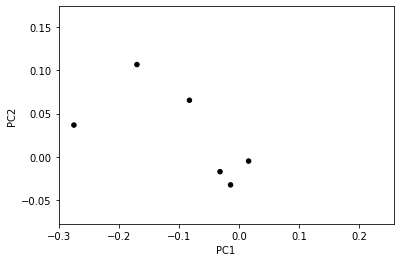

In [104]:
ax1 = to_plot.plot.scatter(x='PC1', y='PC2', color=to_plot['Predicted'])



In [50]:
#list(filter( lambda model: model.ready(), models))
y_train

level_0
2019-05-17    0.002613
2019-05-20    0.000613
2019-05-21   -0.013174
2019-05-22    0.006830
2019-05-23   -0.002467
                ...   
2021-01-25   -0.012941
2021-01-26   -0.005520
2021-01-27   -0.018907
2021-01-28    0.009547
2021-01-29    0.008406
Name: index, Length: 432, dtype: float64

In [55]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

params={'n_estimators': 10000, 'learning_rate': 0.01, 'max_features': 30, 'max_depth': 4, 'random_state': 0}

parameter_space = {
    "alpha": [0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
    'learning_rate': [0.1,0.2,0.3,0.4,0.5],
    'max_depth': [2,4,6,8,10],
    'max_features': [10,20,30,40,50,60],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,5,10],
    'n_estimators': [500,1000,2000,3000,4000,5000],
    'random_state': [0,1,2,3,4,5,6],
    'warm_start': [False,True]
}

#base_estimator = GradientBoostingRegressor()
#gb_reg.fit(X_train, y_train)

sh = GridSearchCV(GradientBoostingRegressor(), parameter_space, n_jobs=8, pre_dispatch=16)
sh.fit(X_train, y_train)

KeyboardInterrupt: 

In [100]:
gb_reg.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 4,
 'max_features': 30,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train=ftse_prediction[train_mask(ftse_prediction)][test_cols]
y_train=ftse_prediction[train_mask(ftse_prediction)]['target'].astype('int')
X_test = ftse_prediction[test_mask(ftse_prediction)][test_cols]
y_test = ftse_prediction[test_mask(ftse_prediction)]['target'].astype('int')

clf = SVC(kernel='sigmoid')

clf.fit(X=features_train,y=target_train)
y_pred = clf.predict(features_test)
print(accuracy_score(y_test,y_pred))

0.6428571428571429


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  # Remove the CWD from sys.path while we load stuff.
/home/rory/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [119]:
print(SVC.__doc__)

C-Support Vector Classification.

    The implementation is based on libsvm. The fit time scales at least
    quadratically with the number of samples and may be impractical
    beyond tens of thousands of samples. For large datasets
    consider using :class:`sklearn.svm.LinearSVC` or
    :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
    :class:`sklearn.kernel_approximation.Nystroem` transformer.

    The multiclass support is handled according to a one-vs-one scheme.

    For details on the precise mathematical formulation of the provided
    kernel functions and how `gamma`, `coef0` and `degree` affect each
    other, see the corresponding section in the narrative documentation:
    :ref:`svm_kernels`.

    Read more in the :ref:`User Guide <svm_classification>`.

    Parameters
    ----------
    C : float, default=1.0
        Regularization parameter. The strength of the regularization is
        inversely proportional to C. Must be strictly positive. The p

In [109]:
last_week = ftse_basket.get_historical_prices(range='1w')

last_week = process_basket_data(last_week)
last_week_data = normalise_basket(last_week, 'returns')
last_week_data

features = last_week_data[list(filter(lambda col: col not in ['filter', 'target'], last_week_data.columns))]

features = features[features.replace([np.inf, -np.inf], np.nan).notnull()]
features = features[filter(lambda item: item not in ['target', 'index'] ,ftse_prediction.columns)]

last_week_target = ftse100.get_historical_prices(range='1w').close.astype('float').pct_change()
features['target'] = last_week_target

features

,AAL-LN,ABF-LN,ADM-LN,AHT-LN,ANTO-LN,AUTO-LN,AV.-LN,AVV-LN,AZN-LN,BA.-LN,...,STJ-LN,SVT-LN,TSCO-LN,TW.-LN,ULVR-LN,UU.-LN,VOD-LN,WPP-LN,WTB-LN,target
2021-03-02,-0.143746,-0.684988,2.359227,1.663758,-0.763949,-0.891150,2.276241,2.914591,6.692308,-0.749494,...,0.525676,0.990152,-0.902840,-0.945784,1.464124,0.521724,-0.958054,0.068882,15.250000,NaN
2021-03-03,0.009298,0.006760,-0.016563,0.028975,-0.005666,0.011311,0.027346,-0.014773,-0.012500,0.007265,...,0.030894,-0.024741,-0.002698,0.059976,0.000000,-0.020394,0.008698,0.031087,0.055490,0.009392
2021-03-04,-0.032831,-0.000420,-0.026692,-0.022037,-0.062958,-0.012583,0.012265,-0.014418,0.009273,-0.003406,...,-0.042192,0.018911,-0.011271,-0.019050,0.011018,0.019894,0.003833,-0.020687,-0.016134,-0.000338
2021-03-05,0.009179,-0.010915,-0.033954,-0.027541,-0.000290,-0.020885,0.006445,-0.022528,0.000146,-0.027945,...,-0.003294,0.012675,0.021432,-0.009275,0.009600,0.020186,-0.009227,-0.002022,-0.035058,-0.004654
2021-03-08,0.036039,0.002547,-0.009125,0.039135,0.021437,0.002531,0.016137,0.016761,0.021435,0.026680,...,0.028501,-0.014752,-0.018750,0.045348,-0.000257,-0.021120,0.012042,0.038280,0.042778,0.013347
2021-03-09,-0.044062,0.021169,0.005457,0.037661,-0.012479,0.028850,-0.002017,0.016780,0.017987,0.005036,...,-0.004418,0.013158,0.006369,0.002239,0.006941,0.015671,0.012851,-0.013012,-0.017421,0.002852


In [111]:
print(gb_clf.predict(features[test_cols].dropna()))

[1 0 0 0 0]


In [112]:
last_week_target

2021-03-02         NaN
2021-03-03    0.009392
2021-03-04   -0.000338
2021-03-05   -0.004654
2021-03-08    0.013347
2021-03-09    0.002852
Name: close, dtype: float64